In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import networkx as nx

import math

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from src.depth import DepthPoset
from src.complexes import CubicalTorusComplex
from src import depth_poset_similarity_scores
from src import poset_scores, node_scores
from src.transpositions import Transposition

import inspect

from tqdm.notebook import tqdm
import time

import itertools

import imageio as io
from PIL import Image

# Cubical Torus

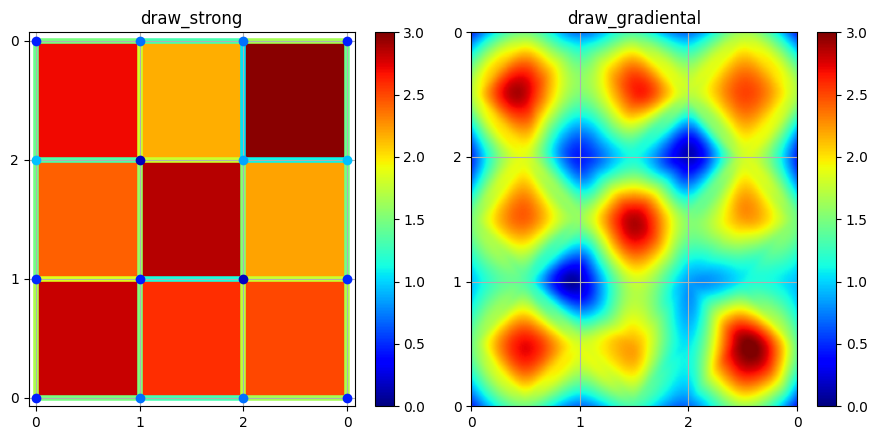

In [3]:
shape = 3, 3

ctc = CubicalTorusComplex(shape)
ctc.assign_random_barycentric_filtration()

if len(shape) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

    axs[0].set_title('draw_strong')
    sm0 = ctc.draw_strong(ax=axs[0], vmin=0, vmax=len(shape) + 1)
    axs[1].set_title('draw_gradiental')
    sm1 = ctc.draw_gradiental(ax=axs[1], vmin=0, vmax=len(shape) + 1)

    for i in range(2):
        axs[i].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
        axs[i].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
        axs[i].grid(True)

    eps = 0.07
    axs[0].set_xlim(0 - eps, shape[0] + eps)
    axs[0].set_ylim(0 - eps, shape[1] + eps)

    plt.colorbar(sm0, ax=axs[0])
    plt.colorbar(sm1, ax=axs[1])
    plt.tight_layout()
    plt.show()


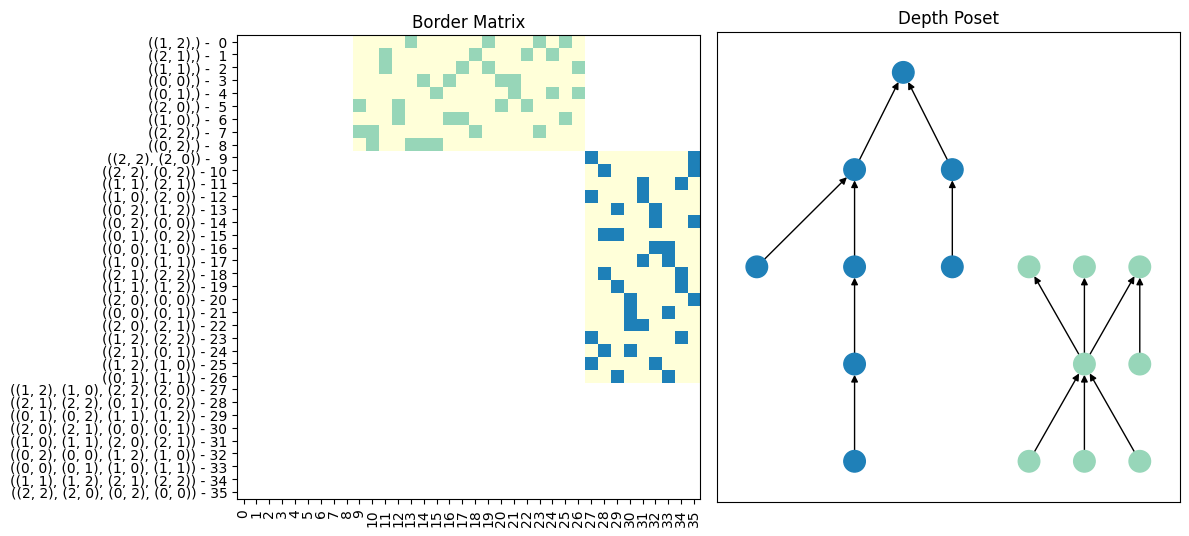

In [4]:
sort_with_filtration = True

order, dims, fvals = ctc.get_order(sort_with_filtration=sort_with_filtration, return_dims=True, return_filtration=True)
bm = ctc.get_border_matrix(sort_with_filtration=sort_with_filtration)
dp = ctc.get_depth_poset(sort_with_filtration=sort_with_filtration)

bm_show = bm.astype(float)*dims
bm_show[dims.reshape(-1, 1) - dims.reshape(1, -1) != -1] = np.nan





fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
cmap = plt.get_cmap('YlGnBu')

axs[0].set_title('Border Matrix')
axs[0].imshow(bm_show, cmap=cmap, vmax=3)
axs[0].set_yticks(np.arange(len(order)), [f'{val} -{i:>3}' for i, val in enumerate(order)], rotation=0)
axs[0].set_xticks(np.arange(len(order)), np.arange(len(order)), rotation=90)

axs[1].set_title('Depth Poset')
g = dp.get_transitive_reduction()
pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
nx.draw_networkx(g, pos=pos, node_color=[cmap((node.dim + 1)/(ctc.dim + 1)) for node in dp.nodes], node_size=240,
                 with_labels=False, ax=axs[1])

plt.tight_layout()
plt.show()

# Poset Scores

In [5]:
df_poset_scores = {}

for name, score in inspect.getmembers(poset_scores, inspect.isfunction):
    df_poset_scores.update({name: {'full': score(dp), 
                                   'subposet dim 0': score(dp.subposet_dim(0)), 
                                   'subposet dim 1': score(dp.subposet_dim(1)), 
                            }})

df_poset_scores = pd.DataFrame(df_poset_scores).transpose()
df_poset_scores

,full,subposet dim 0,subposet dim 1
avarage_maximal_chain,3.076923,2.9,3.666667
cycles_dimension,0.000000,0.0,0.000000
height,4.000000,2.0,4.000000
minimum_maximal_chain,2.000000,2.0,3.000000
number_of_components,2.000000,1.0,1.000000
number_of_edges_in_closure,31.000000,16.0,15.000000
number_of_edges_in_reduction,14.000000,7.0,7.000000
number_of_maximal_nodes,4.000000,3.0,1.000000
number_of_minimal_nodes,7.000000,4.0,3.000000
number_of_nodes,16.000000,8.0,8.000000


In [6]:
df_node_scores = {}

for name, score in inspect.getmembers(node_scores, inspect.isfunction):
    df_node_scores.update({name: {'full': [score(dp, node) for node in dp.nodes],
                                  'subposet dim 0': [score(dp.subposet_dim(0), node) for node in dp.subposet_dim(0).nodes], 
                                  'subposet dim 1': [score(dp.subposet_dim(1), node) for node in dp.subposet_dim(1).nodes],
                            }})

df_node_scores = pd.DataFrame(df_node_scores).transpose()

df_node_scores.applymap(np.mean)

/tmp/ipykernel_62307/1981805424.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_node_scores.applymap(np.mean)


,full,subposet dim 0,subposet dim 1
ancestors_cycles_dimension,0.0000,0.000,0.000
ancestors_height,0.5625,0.375,0.750
ancestors_number,1.9375,2.000,1.875
ancestors_width,1.3125,1.625,1.000
incomparable_number,11.1250,3.000,3.250
successors_cycles_dimension,0.0000,0.000,0.000
successors_height,0.6875,0.375,1.000
successors_number,1.9375,2.000,1.875
successors_width,1.2500,1.625,0.875


# Compare 2 complexes

## Define complexes

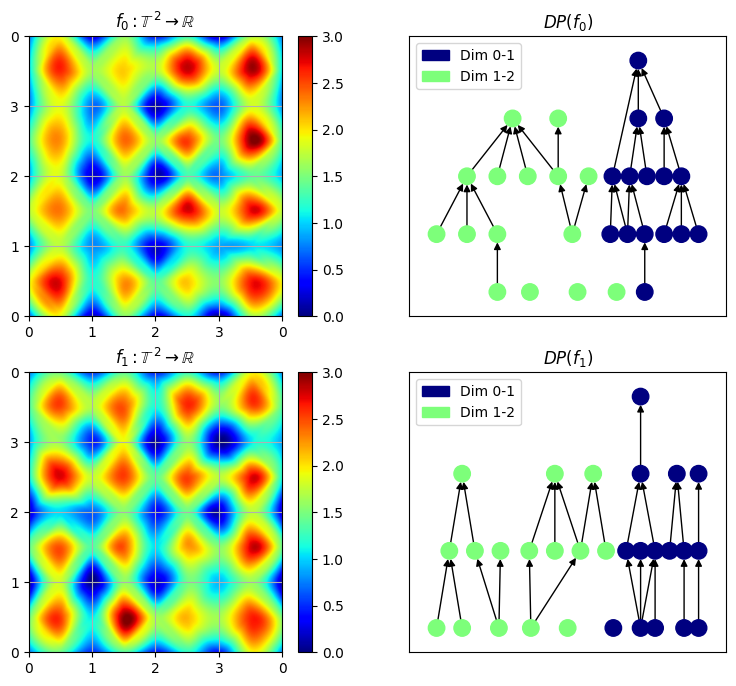

In [7]:
shape = 4, 4

ctc0 = CubicalTorusComplex(shape)
ctc0.assign_random_barycentric_filtration()

ctc1 = CubicalTorusComplex(shape)
ctc1.assign_random_barycentric_filtration()

fvals0 = ctc0.filtration_values
fvals1 = ctc1.filtration_values

t = 0.0
fvals0_new = [m0*(1 - t) + m1*t for m0, m1 in zip(fvals0, fvals1)]
fvals1_new = [m0*t + m1*(1 - t) for m0, m1 in zip(fvals0, fvals1)]
ctc0.assign_filtration(fvals0_new)
ctc1.assign_filtration(fvals1_new)

dp0 = ctc0.get_depth_poset()
dp1 = ctc1.get_depth_poset()

fig, axs = plt.subplots(2, 2, figsize=(9, 8))

cmap_filtration = plt.get_cmap('jet')
cmap_dimensions = plt.get_cmap('jet')
for i, (ctc, dp) in enumerate([(ctc0, dp0), (ctc1, dp1)]):
    if len(shape) == 2:
        axs[i, 0].set_title(f'$f_{i}:\\mathbb{{T}}\\;^{{{len(shape)}}} \\to \\mathbb{{R}}$')
        sm = ctc.draw_gradiental(ax=axs[i, 0], cmap=cmap_filtration, vmin=0, vmax=len(shape) + 1)
        plt.colorbar(sm, ax=axs[i, 0])
        
        axs[i, 0].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
        axs[i, 0].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
        axs[i, 0].grid(True)
    
    
    axs[i, 1].set_title(f'$DP(f_{i})$')
    g = dp.get_transitive_reduction()
    pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
    nx.draw_networkx(g, pos=pos, node_color=[cmap_dimensions(node.dim/ctc.dim) for node in dp.nodes], node_size=140,
                    with_labels=False, ax=axs[i, 1])
    handles = [mpatches.Patch(color=cmap_dimensions(dim/ctc.dim), label=f"Dim {dim}-{dim + 1}") for dim in range(ctc.dim)]
    axs[i, 1].legend(handles=handles, title=None, loc="best")


## Similarity

In [8]:
sim_scores = [f for _, f in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction) if inspect.getmodule(f) == depth_poset_similarity_scores]

df_sim = pd.Series({(score.__name__.replace('cell', '').replace('index', '').replace('__', '_'), score.__name__.find('cell') != -1): score(dp0, dp1) for score in sim_scores})
df_sim = df_sim.unstack(level=1).rename(columns={False: 'by indices', True: 'by cells'})
df_sim

,by indices,by cells
birth_relation_similarity,0.0,0.000000
death_relation_similarity,0.0,0.000000
poset_arc_similarity,0.0,0.000000
poset_node_similarity,0.0,0.071429
relation_similarity,0.0,0.000000


## Linear Homotopy

## Cross parameters

In [9]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

/tmp/ipykernel_62307/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


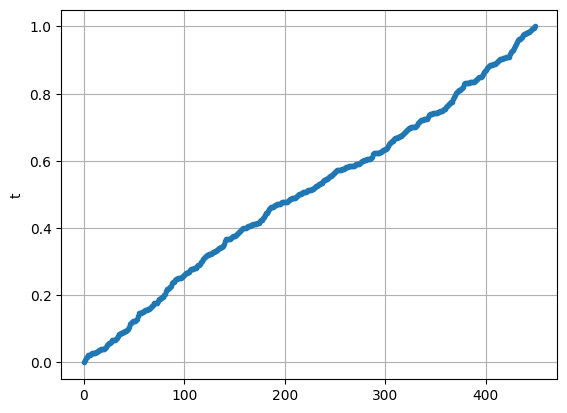

In [10]:
cross_parameters = [get_cross_parameters(m0.flatten(), m1.flatten()) for m0, m1 in zip(fvals0, fvals1)]
#cross_parameters = [m0.flatten()*(1 - t) + m1.flatten()*t for m0, m1, t in zip(fvals0, fvals1, cross_parameters)]
cross_parameters = np.unique(np.concatenate([m.flatten() for m in cross_parameters]))
cross_parameters = np.sort(cross_parameters[~np.isnan(cross_parameters)])

ts = np.unique(np.concatenate([0.5*(cross_parameters[1:] + cross_parameters[:-1]), [0, 1]]))

plt.plot(ts, marker='.')
plt.grid(True)
plt.ylabel('t')
plt.show()

## Similarity Scores

## Gif-Image

## Transpositions

In [11]:
class Timer:
    def __enter__(self):
        self.checkpoints = [time.perf_counter()]
        return self
    
    def checkpoint(self):
        self.checkpoints.append(time.perf_counter())

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.checkpoint()
        self.duration = self.checkpoints[-1] - self.checkpoints[0]

    def elapsed(self):
        return time.perf_counter() - self.checkpoints[-1]

    def get_duration(self):
        try:
            return self.duration
        except NameError:
            return self.elapsed()



In [12]:
tqdm.pandas()

In [13]:
def get_flat_add(dim, shape):
    # 
    return int(np.sum([math.comb(len(shape), i) for i in range(dim)])*np.prod(shape))

In [14]:
with Timer() as timer:

    cross_parameters = [get_cross_parameters(m0.flatten(), m1.flatten()) for m0, m1 in zip(fvals0, fvals1)]
    eps = np.concatenate([m.flatten() for m in cross_parameters] + [[0, 1]])
    eps = np.unique(eps[~np.isnan(eps)])
    eps = 0.8*(eps[1:] - eps[:-1]).min()

    cross_parameters_id_flat = [np.unique(np.sort(np.argwhere(~np.isnan(i)), axis=1), axis=0) for i in cross_parameters]

    df_transpositions = pd.DataFrame()
    df_transpositions['id0_flat'] = np.concatenate(cross_parameters_id_flat)[:, 0]
    df_transpositions['id1_flat'] = np.concatenate(cross_parameters_id_flat)[:, 1]
    df_transpositions['dim'] = np.concatenate([d*np.ones(len(i), dtype=int) for d, i in enumerate(cross_parameters_id_flat)])
    df_transpositions['shape'] = df_transpositions['dim'].apply(lambda x: math.comb(len(shape), x))
    df_transpositions['shape'] = df_transpositions['shape'].apply(lambda x: (x, ) + shape)
    df_transpositions['id0_volume'] = df_transpositions.apply(lambda row: np.unravel_index(row['id0_flat'], row['shape']), axis=1)
    df_transpositions['id1_volume'] = df_transpositions.apply(lambda row: np.unravel_index(row['id1_flat'], row['shape']), axis=1)

    df_transpositions['time'] = df_transpositions.apply(lambda row: cross_parameters[row['dim']][row['id0_flat'], row['id1_flat']], axis=1)

    print(f'The time values of transpositions have been found in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()

    df_transpositions['id0_flat'] = df_transpositions.apply(lambda row: row['id0_flat'] + get_flat_add(row['dim'], shape), axis=1)
    df_transpositions['id1_flat'] = df_transpositions.apply(lambda row: row['id1_flat'] + get_flat_add(row['dim'], shape), axis=1)

    order = ctc0.get_order(sort_with_filtration=False)
    df_transpositions['cell0'] = df_transpositions['id0_flat'].apply(lambda i: order[i])
    df_transpositions['cell1'] = df_transpositions['id1_flat'].apply(lambda i: order[i])

    print(f'The cells have been defined in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()

    df_transpositions['complex'] = df_transpositions.progress_apply(lambda row: CubicalTorusComplex(shape).assign_filtration([m0*(1 - (row['time'] - eps)) + m1*(row['time'] - eps) for m0, m1 in zip(fvals0, fvals1)]), axis=1)
    df_transpositions['order&dims'] = df_transpositions['complex'].progress_apply(lambda x: x.get_order(sort_with_filtration=True, return_filtration=False, return_dims=True))
    df_transpositions['order'] = df_transpositions['order&dims'].apply(lambda x: x[0])
    df_transpositions['dims'] = df_transpositions['order&dims'].apply(lambda x: x[1])
    df_transpositions = df_transpositions.drop(columns='order&dims')

    print(f'The complexes and the orders during homotopy have been found in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()

    df_transpositions['id0_order'] = df_transpositions.apply(lambda row: row['order'].index(row['cell0']), axis=1)
    df_transpositions['id1_order'] = df_transpositions.apply(lambda row: row['order'].index(row['cell1']), axis=1)


    to_reverse = df_transpositions['id1_order'] - df_transpositions['id0_order'] == -1
    i0_vals = df_transpositions.loc[to_reverse, 'id0_order']
    i1_vals = df_transpositions.loc[to_reverse, 'id1_order']
    df_transpositions.loc[to_reverse, 'id0_order'] = i1_vals
    df_transpositions.loc[to_reverse, 'id1_order'] = i0_vals

    assert (df_transpositions['id1_order'] - df_transpositions['id0_order'] == 1).all()

    print(f'The orders during homotopy have been found in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()

    df_transpositions['border matrix'] = df_transpositions['complex'].progress_apply(lambda x: x.get_border_matrix(sort_with_filtration=True))

    print(f'The complexes and the orders dborder matrices during homotopy have been found in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()

    df_transpositions['dp'] = df_transpositions['complex'].progress_apply(lambda x: x.get_depth_poset(sort_with_filtration=True))

    print(f'The depth posets during homotopy have been found in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()

    df_transpositions['transposition'] = df_transpositions.progress_apply(
        lambda row: 
        Transposition(border_matrix=row['border matrix'], 
                    index0=row['id0_order'], 
                    index1=row['id1_order'], 
                    order=row['order'], 
                    dims=row['dims'], 
                    dp=row['dp']), 
        axis=1
    )
    print(f'The transpositions themselves during homotopy have been found in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()

    df_transpositions = df_transpositions.drop(columns=['dim'] + list(np.concatenate([[f'id{i}_flat', f'id{i}_volume', f'id{i}_order', f'cell{i}'] for i in range(2)])))

    df_transpositions = pd.concat([pd.DataFrame(df_transpositions['transposition'].apply(lambda tr: tr.to_dict()).to_list(), index=df_transpositions.index), df_transpositions], axis=1)


print(f'Everything is found in found in {timer.get_duration():.4f} seconds.')
timer.checkpoint()

print(f'\ndf_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

/tmp/ipykernel_62307/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


The time values of transpositions have been found in 0.0168 seconds.
The cells have been defined in 0.0146 seconds.


  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

The complexes and the orders during homotopy have been found in 0.4836 seconds.
The orders during homotopy have been found in 0.0096 seconds.


  0%|          | 0/380 [00:00<?, ?it/s]

The complexes and the orders dborder matrices during homotopy have been found in 0.6773 seconds.


  0%|          | 0/380 [00:00<?, ?it/s]

The depth posets during homotopy have been found in 3.2939 seconds.


  0%|          | 0/380 [00:00<?, ?it/s]

The transpositions themselves during homotopy have been found in 0.0230 seconds.
Everything is found in found in 4.8251 seconds.

df_transpositions.shape = (380, 15)


,index 0,index 1,cell 0,cell 1,dim,type,switch,shape,time,complex,order,dims,border matrix,dp,transposition
0,12,13,"((0, 0),)","((0, 2),)",0,birth-birth,switch backward,"(1, 4, 4)",0.269403,<src.complexes.CubicalTorusComplex object at 0...,"[((2, 1),), ((3, 0),), ((2, 2),), ((2, 3),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x7016867dd760>,"<((0, 0),), ((0, 2),)>"
1,11,12,"((0, 0),)","((0, 3),)",0,birth-birth,no switch,"(1, 4, 4)",0.121060,<src.complexes.CubicalTorusComplex object at 0...,"[((3, 0),), ((2, 1),), ((2, 2),), ((1, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x70168c621580>,"<((0, 0),), ((0, 3),)>"
2,8,9,"((1, 1),)","((0, 0),)",0,birth-birth,no switch,"(1, 4, 4)",0.026548,<src.complexes.CubicalTorusComplex object at 0...,"[((3, 0),), ((2, 1),), ((2, 2),), ((1, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x70168c621f10>,"<((1, 1),), ((0, 0),)>"
3,10,11,"((0, 0),)","((1, 3),)",0,birth-birth,no switch,"(1, 4, 4)",0.118085,<src.complexes.CubicalTorusComplex object at 0...,"[((3, 0),), ((2, 1),), ((2, 2),), ((1, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x70168c622840>,"<((0, 0),), ((1, 3),)>"
4,9,10,"((0, 0),)","((3, 2),)",0,birth-birth,no switch,"(1, 4, 4)",0.066993,<src.complexes.CubicalTorusComplex object at 0...,"[((3, 0),), ((2, 1),), ((2, 2),), ((1, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",<src.depth.DepthPoset object at 0x70168c623230>,"<((0, 0),), ((3, 2),)>"


In [15]:
df_transpositions[['dim', 'type', 'switch']].value_counts().reset_index().pivot_table(columns=['switch'], index=['dim', 'type'], values='count').fillna(0).astype(int)

switch                 no switch  switch backward  switch forward  undefined
dim type                                                                    
0   birth-birth               34                4               0          0
    birth-unpaired             0                0               0          3
1   birth-birth              105                5               6          0
    birth-death               29                0              12          0
    birth-unpaired             0                0               0          5
    death-death               65                6               6          0
    death-unpaired             0                0               0         28
    unpaired-unpaired          0                0               0          2
2   death-death               50                1               2          0
    death-unpaired             0                0               0          1

# The Torus Size / Number of Transpositions Relation

In [16]:
ns = np.arange(3, 9)
dims = [1, 2]
repeat = 100

In [17]:
df_cases = []

for dim, n, _ in tqdm(itertools.product(dims, ns, range(repeat)), total=len(ns)*len(dims)*repeat):
    this_shape = [n for i in range(dim)]
    ctc0 = CubicalTorusComplex(this_shape)
    ctc0.assign_random_barycentric_filtration()

    ctc1 = CubicalTorusComplex(this_shape)
    ctc1.assign_random_barycentric_filtration()

    fvals0 = ctc0.filtration_values
    fvals1 = ctc1.filtration_values

    cross_parameters = [get_cross_parameters(m0.flatten(), m1.flatten()) for m0, m1 in zip(fvals0, fvals1)]
    n_transpositions = [np.sum((~np.isnan(m))&(np.triu(np.ones(m.shape, dtype=bool)))) for m in cross_parameters]
    
    df_cases.append({'dim': dim, 'n': n})
    for i, n in enumerate(n_transpositions):
        df_cases[-1].update({f'transpositions {i}': n})

df_cases = pd.DataFrame(df_cases)
df_cases = df_cases.fillna(0)

df_cases.insert(2, 'cells', (2*df_cases['n'])**df_cases['dim'])


print(f'df_cases.shape = {df_cases.shape}')
df_cases.head()

  0%|          | 0/1200 [00:00<?, ?it/s]

/tmp/ipykernel_62093/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


df_cases.shape = (1200, 6)


,dim,n,cells,transpositions 0,transpositions 1,transpositions 2
0,1,3,6,3,2,0.0
1,1,3,6,3,0,0.0
2,1,3,6,1,1,0.0
3,1,3,6,2,2,0.0
4,1,3,6,3,0,0.0


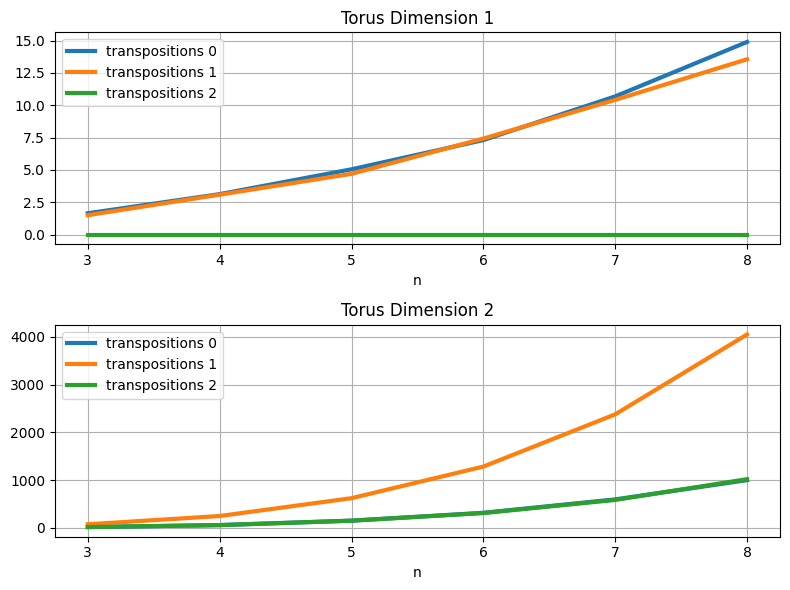

In [18]:
fig, axs = plt.subplots(len(dims), figsize=(8, 3*len(dims)))

for i, dim in enumerate(dims):
    axs[i].set_title(f'Torus Dimension {dim}')
    df_cases[df_cases['dim'] == dim].drop(columns=['cells', 'dim']).groupby('n').mean().plot(linewidth=3, ax=axs[i])
    axs[i].grid(True)

plt.tight_layout()


In [19]:
df_cases.drop(columns=['cells']).groupby(['dim', 'n']).mean()#.sum(axis=1)

transpositions 0  transpositions 1  transpositions 2
dim n                                                      
1   3              1.65              1.50              0.00
    4              3.13              3.09              0.00
    5              5.05              4.70              0.00
    6              7.31              7.43              0.00
    7             10.69             10.42              0.00
    8             14.90             13.56              0.00
2   3             18.31             76.62             17.73
    4             58.92            249.42             59.65
    5            152.47            622.53            151.72
    6            316.71           1283.52            311.34
    7            597.24           2376.31            585.89
    8            999.83           4047.74           1019.70

In [20]:
df_cases.drop(columns=['cells']).groupby(['dim', 'n']).std()

transpositions 0  transpositions 1  transpositions 2
dim n                                                      
1   3          0.957427          0.915633          0.000000
    4          1.561241          1.378735          0.000000
    5          1.882267          2.120130          0.000000
    6          2.611919          2.992432          0.000000
    7          3.308071          3.693237          0.000000
    8          3.937645          3.898510          0.000000
2   3          4.879756         13.907181          4.199218
    4         10.813086         30.304575         11.162143
    5         18.585024         60.509362         20.041412
    6         30.970268        101.961320         34.402613
    7         57.442307        178.946338         53.193357
    8         84.320703        268.546015         91.236677

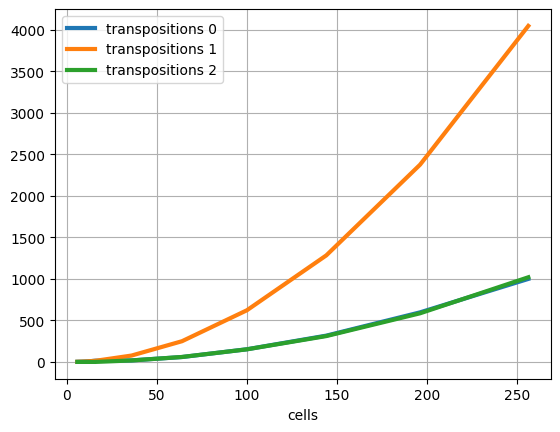

In [21]:
df_cases.drop(columns=['n', 'dim']).groupby('cells').mean().plot(linewidth=3)
plt.grid(True)
plt.show()

In [22]:
df_cases.drop(columns=['n', 'dim']).groupby('cells').mean()

,transpositions 0,transpositions 1,transpositions 2
cells,,,
6,1.65,1.50,0.00
8,3.13,3.09,0.00
10,5.05,4.70,0.00
12,7.31,7.43,0.00
14,10.69,10.42,0.00
16,14.90,13.56,0.00
36,18.31,76.62,17.73
64,58.92,249.42,59.65
100,152.47,622.53,151.72


In [16]:
path = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses/2025-06-17 17:34:21.643459 and 2025-06-17 17:34:28.994766.pkl"
df_load = pd.read_pickle(path)

print(f'df_load.shape = {df_load.shape}')
df_load.head()

df_load.shape = (95, 19)


,complex_index0,complex_index1,complex_dim,complex_shape,index 0,index 1,cell 0,cell 1,dim,type,switch,shape,time,complex,order,dims,border matrix,dp,transposition
0,2025-06-17 17:34:21.643459,2025-06-17 17:34:28.994766,2,"(3, 3)",3,4,"((0, 0),)","((1, 2),)",0,birth-birth,no switch,"(1, 3, 3)",0.405332,<src.complexes.CubicalTorusComplex object at 0...,"[((2, 2),), ((2, 1),), ((2, 0),), ((0, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",<src.depth.DepthPoset object at 0x7016865132f0>,"<((0, 0),), ((1, 2),)>"
1,2025-06-17 17:34:21.643459,2025-06-17 17:34:28.994766,2,"(3, 3)",2,3,"((0, 0),)","((2, 0),)",0,birth-birth,no switch,"(1, 3, 3)",0.641693,<src.complexes.CubicalTorusComplex object at 0...,"[((2, 1),), ((2, 2),), ((0, 0),), ((2, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",<src.depth.DepthPoset object at 0x70168c378050>,"<((0, 0),), ((2, 0),)>"
2,2025-06-17 17:34:21.643459,2025-06-17 17:34:28.994766,2,"(3, 3)",1,2,"((0, 0),)","((2, 2),)",0,birth-birth,no switch,"(1, 3, 3)",0.790046,<src.complexes.CubicalTorusComplex object at 0...,"[((2, 1),), ((0, 0),), ((2, 2),), ((2, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...",<src.depth.DepthPoset object at 0x70168c378e60>,"<((0, 0),), ((2, 2),)>"
3,2025-06-17 17:34:21.643459,2025-06-17 17:34:28.994766,2,"(3, 3)",5,6,"((0, 1),)","((1, 0),)",0,birth-birth,no switch,"(1, 3, 3)",0.288763,<src.complexes.CubicalTorusComplex object at 0...,"[((2, 2),), ((2, 0),), ((2, 1),), ((1, 2),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",<src.depth.DepthPoset object at 0x70168c379c70>,"<((0, 1),), ((1, 0),)>"
4,2025-06-17 17:34:21.643459,2025-06-17 17:34:28.994766,2,"(3, 3)",6,7,"((0, 1),)","((1, 1),)",0,birth-birth,no switch,"(1, 3, 3)",0.489931,<src.complexes.CubicalTorusComplex object at 0...,"[((2, 1),), ((2, 2),), ((2, 0),), ((0, 0),), (...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",<src.depth.DepthPoset object at 0x70168c37a9f0>,"<((0, 1),), ((1, 1),)>"


In [17]:
df_load[['dim', 'type', 'switch']].value_counts().reset_index().pivot_table(columns=['switch'], index=['dim', 'type'], values='count').fillna(0).astype(int)

switch              no switch  switch backward  switch forward  undefined
dim type                                                                 
0   birth-birth             8                3               0          0
    birth-unpaired          0                0               0          2
1   birth-birth            22                1               3          0
    birth-death             2                0               4          0
    birth-unpaired          0                0               0          5
    death-death            15                2               2          0
    death-unpaired          0                0               0         11
2   death-death            12                1               2          0